In [1]:
import nibabel as nib 
#! pip install nibabel --user
import os
import glob
import numpy as np
from nibabel.testing import data_path
import matplotlib.pyplot as plt
#import cv2
#! pip install cv2 --user
import time
from datetime import datetime
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.ndimage import zoom
import pandas as pd
import os
from skimage.io import imread
from skimage.color import gray2rgb
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torchvision as tv
from torch.utils.data import (
    Dataset,
    DataLoader,
)
import matplotlib.pyplot as plt
from torch.utils import data as DT
from skimage.transform import radon , iradon
%matplotlib inline
!pip install livelossplot --quiet
from livelossplot import PlotLosses
from sklearn.metrics import r2_score , mean_squared_error
from sklearn import metrics

In [2]:
###pad function to resize all images to specific size (here: 64*64*64)

def pad(img_,size_):
    dif=size_-img_.shape[0]
    if dif%2==0:
        img_=np.pad(img_,((dif//2,dif//2),(0,0),(0,0)),'edge')
    else:
        img_=np.pad(img_,(((dif-1)//2,(dif+1)//2),(0,0),(0,0)),'edge')
    dif=size_-img_.shape[1]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(dif//2,dif//2),(0,0)),'edge')
    else:
        img_=np.pad(img_,((0,0),((dif-1)//2,(dif+1)//2),(0,0)),'edge')
    dif=size_-img_.shape[2]
    if dif%2==0:
        img_=np.pad(img_,((0,0),(0,0),(dif//2,dif//2)),'edge')
    else:
        img_=np.pad(img_,((0,0),(0,0),((dif-1)//2,(dif+1)//2)),'edge')
    return img_

In [15]:
# method to save the model
def save_checkpoint(state, filename="my_checkpoint2.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

#method to load the saved checkpoint
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [4]:
#load all PET and segmentation images(these images are already resampled and have the size of [almost] 64*64*64)
#and add padding if needed

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'

files = [f for f in glob.glob(path + "**/*_ct_gtvt.nii.gz", recursive=True)]
labels_lenght=list()
image_list=list()
label_list=list()
CT_list=list()

for idx,f in enumerate(files):
    SEG_img = nib.load(f)
    SEG_data = SEG_img.get_fdata()
    if SEG_data.shape!=(64,64,64):
        SEG_data=pad(SEG_data,64)
    label_list.append(SEG_data)
    path=f[:-15]+'_pt.nii.gz'
    im=nib.load(path)
    PET_data=im.get_fdata()
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    image_list.append(PET_data)
    path=f[:-15]+'_ct.nii.gz'
    im=nib.load(path)
    CT_data=im.get_fdata()
    if CT_data.shape!=(64,64,64):
        CT_data=pad(CT_data,64)
    CT_list.append(CT_data)
    #print(idx)


In [6]:
#make label patch of 16*16*16

size = 16 # patch size
stride = 16 # patch stride

all_labels_1=list()
all_labels_2=list()
all_labels_num=list()
all_seg_img=list()

for seg_img in label_list:
    #positive_cells_number=np.sum(seg_img)
    #print("positive_cells_number",positive_cells_number)
    patches = torch.from_numpy(seg_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size)
    #labels_1=(torch.sum(reshaped_patches , dim=(1,2)).int().numpy())/positive_cells_number
    labels_2=(torch.sum(reshaped_patches , dim=(1,2)).int().numpy())/(size*size)

    #print ("labels_", labels_)
    #print ("labels_2", labels_2)
    all_seg_img.append(reshaped_patches)
    #all_labels_1.append(labels_1)
    all_labels_2.append(labels_2)
    all_labels_num.append((torch.sum(reshaped_patches , dim=(1,2)).int().numpy()))
all_labels_num=np.asarray(all_labels_num).reshape(-1)
#all_labels_1=np.asarray(all_labels_1).reshape(-1)
all_labels=np.asarray(all_labels_2).reshape(-1)
#all_seg_img=np.asarray(all_seg_img).reshape(-1)

In [7]:
#make PET_image patch of 16*16*16

all_PET_patches=list()
for PET_img in image_list:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_PET_patches.append(reshaped_patches)
all_PET_patches=np.asarray(all_PET_patches).reshape(-1,size,size)

In [8]:
#make CT_image patch of 16*16*16

all_CT_patches=list()
for CT_img in CT_list:
    patches = torch.from_numpy(CT_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_CT_patches.append(reshaped_patches)
all_CT_patches=np.asarray(all_CT_patches).reshape(-1,size,size)

In [9]:
class HN_Dataset(Dataset):
    def __init__(self, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.PET_images=all_PET_patches
        self.CT_images=all_CT_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            #PET_data = self.transform((np.concatenate((all_PET_patches[idx][np.newaxis,:],all_CT_patches[idx][np.newaxis,:]),axis=0)))
            #PET_data = ((np.concatenate((all_PET_patches[idx][np.newaxis,:],all_CT_patches[idx][np.newaxis,:]),axis=0)))
            PET_data = self.transform(all_PET_patches[idx])
        return (PET_data, label)

In [10]:
len (all_labels)

204800

In [11]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters

num_epochs = 30
learning_rate = 5e-4
batch_size = 64

In [12]:
split_threshold=170000  # to split test and train set (170000 out of 204800 for train set)


#print (all_PET_patches.shape) #number of patches * pactch dim1 * patch dim2 * patch dim3

PET_patch_mean=np.mean(all_PET_patches[:split_threshold] , axis=(0,1,2))
PET_patch_std=np.std(all_PET_patches[:split_threshold] , axis=(0,1,2))


# Load Data

idx = list(range(len(all_labels)))

dataset = HN_Dataset( transform=tv.transforms.ToTensor())
train_set = DT.Subset(dataset, idx[:split_threshold])
test_set = DT.Subset(dataset, idx[split_threshold:])

#train_set, test_set = torch.utils.data.random_split(dataset, [10000, 1800])

train_set.transform= tv.transforms.Compose([tv.transforms.RandomHorizontalFlip(),
                                            tv.transforms.RandomVerticalFlip(),
                                            tv.transforms.ToTensor(),
                                            tv.transforms.Normalize(PET_patch_mean, PET_patch_std)
                                           ])

test_set.transform= tv.transforms.Compose([#tv.transforms.RandomHorizontalFlip(),
                                           #tv.transforms.RandomVerticalFlip(),
                                           tv.transforms.ToTensor()
                                           #tv.transforms.Normalize(PET_patch_mean, PET_patch_std)
                                           ])
#tv.transforms.RandomRotation(180),

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [13]:
class CNN_conv2d(nn.Module):
    def __init__(self, in_channels=16, num_classes=1):
        super(CNN_conv2d, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=(3,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=(3 ,3),
            stride=(1, 1),
            #padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=8,
            out_channels=8,
            kernel_size=(3 ,3),
            stride=(1, 1),
            padding=(1, 1),
        )
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        
        self.fc1 = nn.Linear(16 * 1 * 1, num_classes)
        
        self.sig=nn.Sigmoid()
        
        self.BatchNorm64=nn.BatchNorm2d(64)
        self.BatchNorm32=nn.BatchNorm2d(32)
        self.BatchNorm8=nn.BatchNorm2d(8)
        self.BatchNorm16=nn.BatchNorm2d(16)
        self.dropout= nn.Dropout(p=0.1)
        
        self.initialize_weights()

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.BatchNorm32(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        #x = self.BatchNorm32(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = x.mean([2, 3])
        
        #x = self.conv3(x)
        #x = self.BatchNorm32(x)
        #x = F.relu(x)
        #x = self.pool(x)
        
        #x=self.dropout(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        #x=self.dropout(x)
        x=self.sig(x)
        return x

    

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)

                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)


In [17]:
coef_nonzero=1
coef_zero=0.25

def my_loss(scores, labels):
    idx1=np.argwhere(labels.cpu().numpy()==0).ravel()
    idx2=np.argwhere(labels.cpu().numpy()!=0).ravel()
    
    loss1 = torch.mean((scores[idx1] - labels[idx1])**2)
    loss2 = torch.mean((scores[idx2] - labels[idx2])**2)
    
    if len(idx1)==0:
        loss1=0
        
    if len(idx2)==0:
        loss2=0
    
    
    loss= ((coef_zero*loss1*len(idx1))+(coef_nonzero*loss2*len(idx2)))/(len(idx1)+len(idx2))

    return loss

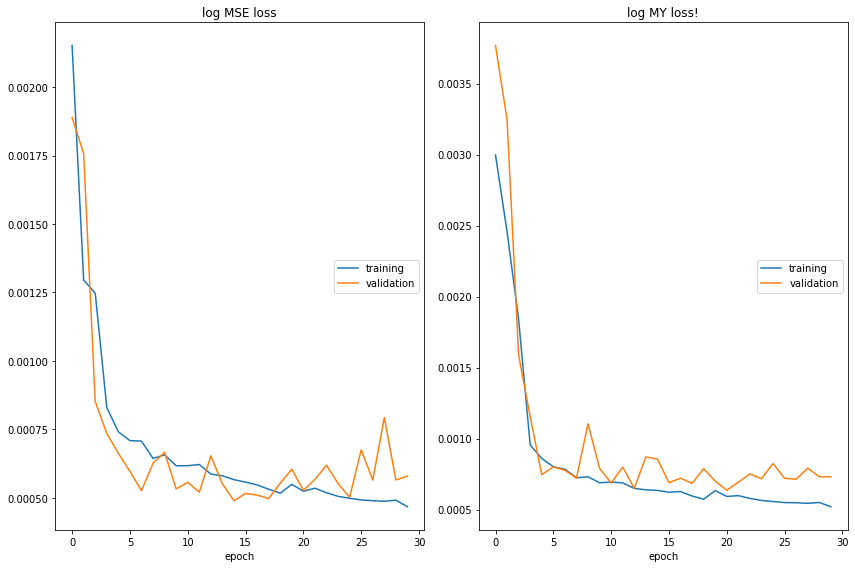

log MSE loss
	training         	 (min:    0.000, max:    0.002, cur:    0.000)
	validation       	 (min:    0.000, max:    0.002, cur:    0.001)
log MY loss!
	training         	 (min:    0.001, max:    0.003, cur:    0.001)
	validation       	 (min:    0.001, max:    0.004, cur:    0.001)


In [40]:
############################## this part is to just observe learning/loss curve. you can skip it.********************
#device=torch.device("cpu")
# Initialize network
///
model = CNN_conv2d().to(device)
liveloss = PlotLosses()

# Loss and optimizer
criterion=nn.MSELoss()
#criterion=my_loss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

load_module=False

ref=1

dataloaders = {
    "train": train_loader,
    "validation": test_loader
}

# Train Network
for epoch in range(num_epochs):
    logs = {}
    for phase in ['train', 'validation']:

        if phase == 'train':
            model.train()
        else:
            model.eval()

            
        running_MSE_loss = 0.0
        running_MY_loss = 0.0
        
        running_corrects = 0.0

        for inputs, labels in dataloaders[phase]:
            # Get data to cuda if possible
            inputs = inputs.to(device=device)
            labels = labels.to(device=device)

            # forward
            inputs=inputs.float()
            scores = model(inputs)
            labels=labels.float()
            scores=scores.view(-1)

            loss = my_loss(scores, labels)
            #loss = criterion(scores, labels)           
            loss2 = criterion(scores, labels)           
            # backward
            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                # gradient descent or adam step
                optimizer.step()
            preds=torch.round(scores)
    
            running_MSE_loss += loss2.detach() * inputs.size(0)
            running_MY_loss += loss.detach() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
        epoch_MSE_loss = running_MSE_loss / len(dataloaders[phase].dataset)            
        epoch_MY_loss = running_MY_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
        
        #if phase == 'validation':
        #    this_loss=(running_loss / len(dataloaders[phase].dataset)).item()
        #    if this_loss<ref:
        #        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        #        # save checkpoint
        #        save_checkpoint(checkpoint)
        #        ref=this_loss
        #        print ("epoch {}:loss{}".format(epoch,ref)) 
        
        prefix = ''
        if phase == 'validation':
            prefix = 'val_'

        logs[prefix + 'log MSE loss'] = epoch_MSE_loss.item()
        logs[prefix + 'log MY loss!'] = epoch_MY_loss.item()
        #logs[prefix + 'accuracy'] = epoch_acc.item()
        
    liveloss.update(logs)
    liveloss.send()



In [43]:
#MAIN
#device = torch.device("cpu")
num_epochs = 31
# Initialize network

model = CNN_conv2d().to(device)

# Loss and optimizer
criterion=nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
load_module=False
print("Current Time =", datetime.now().strftime("%H:%M:%S")) 
# Train Network
for epoch in range(num_epochs):
    now = datetime.now()
    if load_module:
        # load checkpoint
        load_checkpoint(torch.load("my_checkpoint2.pth.tar"), model, optimizer)
        load_module=False
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # forward
        data=data.float()
        scores = model(data)
        targets=targets.float()
        scores=scores.view(-1)

        #loss = criterion(scores, targets)
        loss = my_loss(scores, targets)
        losses.append(loss.item())

        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()
    if (epoch % 10==0):
        print(f"Cost at epoch {epoch} is {np.sum(losses)/len(losses)}")
        print("Current Time =", now.strftime("%H:%M:%S")) 
        checkpoint = {"state_dict": model.state_dict(), "optimizer": optimizer.state_dict()}
        # save checkpoint
        save_checkpoint(checkpoint)
        


Current Time = 18:02:39
Cost at epoch 0 is 0.0013506932058521732
Current Time = 18:02:39
=> Saving checkpoint
Cost at epoch 10 is 0.0003624878424631395
Current Time = 18:11:22
=> Saving checkpoint
Cost at epoch 20 is 0.0003340753544709722
Current Time = 18:20:18
=> Saving checkpoint
Cost at epoch 30 is 0.0002865191469433849
Current Time = 18:30:44
=> Saving checkpoint


In [44]:
# Check accuracy on training to see how good our model is
all_y=list()
all_pred=list()
def check_accuracy(loader, model, test_set):
    _y=list()
    _pred=list()
    all_non_z=list()
    all_z=list()

    total_mse=0
    total_my_loss=0
    model.eval()
    idx=0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x=x.float()
            scores = model(x)
            predictions=scores
            ML=my_loss((predictions),y)
            total_my_loss=total_my_loss+ML
            MSE=mean_squared_error(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy()))
            total_mse=total_mse+MSE
            idx=idx+1
            
            idx1=np.argwhere(y.cpu().numpy()!=0).ravel()
            non_z=torch.mean(scores[idx1])
            all_non_z.append(non_z.cpu().numpy())
            
            idx2=np.argwhere(y.cpu().numpy()==0).ravel()
            _z=torch.mean(scores[idx2])
            all_z.append(_z.cpu().numpy())
            
            
            _y.append(np.ceil(y.cpu().numpy().ravel()))
            _pred.append(predictions.cpu().numpy().ravel())
            
            
            if test_set:
                
                np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
                print ("labels:       ",np.ravel(y.cpu().numpy()))
                print ("predictions:  ",np.ravel((predictions.cpu().numpy())))
                print ("mean_squared_error",MSE)
                #print ("r2_score",r2_score(np.ravel(predictions.cpu().numpy()),np.ravel(y.cpu().numpy())))
    all_non_z=np.array(all_non_z)
    all_non_z[np.isnan(all_non_z)] = 0
    print ("non_zero_labels prediction mean",np.mean(all_non_z))
    
    all_z=np.array(all_z)
    all_z[np.isnan(all_z)] = 0
    print ("zero_label prediction mean",np.mean(all_z))
    
    print ("total_mse",total_mse/idx)
    print ("total_my_loss",total_my_loss.cpu().numpy()/idx) 
    

    fpr, tpr, thresholds = metrics.roc_curve(np.concatenate( _y, axis=0 ),np.concatenate( _pred, axis=0 ))
    print ("AUC",metrics.auc(fpr, tpr))
    all_y.append(_y[:-1])
    all_pred.append(_pred[:-1])
    model.train()


In [45]:
print("Checking accuracy on Training Set: original images")
check_accuracy(train_loader, model ,test_set=False)

print("Checking accuracy on Test Set: original images")
check_accuracy(test_loader, model, test_set=False)

Checking accuracy on Training Set: original images
non_zero_labels prediction mean 0.095459
zero_label prediction mean 0.004629301
total_mse 0.0003960490489537473
total_my_loss 0.0009026238392595626
AUC 0.9449829088193802
Checking accuracy on Test Set: original images
non_zero_labels prediction mean 0.021039866
zero_label prediction mean 0.0050096363
total_mse 0.0005205703183218951
total_my_loss 0.0017854723742121003
AUC 0.9458417969734418


In [21]:
####################if you wanna check all predictions and labels, uncomment following lines
#print("Checking accuracy on Test Set")
#check_accuracy(test_loader, model, test_set=True)

In [22]:
#method to add poisson noise to images

def make_noisy_image(image, PEAK=1):
    img=np.zeros(image.shape)
    for idx, _2d_img in enumerate(image):  
        
        theta = np.linspace(0., 180., max(_2d_img.shape), endpoint=False)
        sinogram = radon(_2d_img, theta=theta, circle=False)
        sinogram=np.clip(sinogram, 0,None)
        noisy = np.random.poisson(sinogram * PEAK)/PEAK  
        img[idx] = iradon(noisy, theta=theta, circle=False)
    return img

In [23]:
#again load all images, add pading if needed, then add poisson noise for 4 different levels

path = 'D:\\Master_courses\\Praktikum\\challenge\\hecktor\\data\\resampled\\'
#_ct_gtvt.nii.gz
#_pt.nii.gz
files = [f for f in glob.glob(path + "**/*_pt.nii.gz", recursive=True)]
noisy_image_list1=list()
noisy_image_list2=list()
noisy_image_list3=list()

for idx,f in enumerate(files):
    
    im=nib.load(f)
    PET_data=im.get_fdata()   
    if PET_data.shape!=(64,64,64):
        PET_data=pad(PET_data,64)
    PET_data1=make_noisy_image(PET_data , 0.1)   
    noisy_image_list1.append(PET_data1)
    PET_data2=make_noisy_image(PET_data , 1)   
    noisy_image_list2.append(PET_data2)
    PET_data3=make_noisy_image(PET_data , 10)   
    noisy_image_list3.append(PET_data3)
    


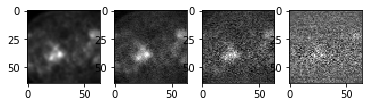

In [24]:
fig = plt.figure()
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(image_list[0][:,:,50],cmap='gray')
a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(noisy_image_list3[0][:,:,50],cmap='gray')
a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(noisy_image_list2[0][:,:,50],cmap='gray')
a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(noisy_image_list1[0][:,:,50],cmap='gray')



In [46]:
#make image patches of size 16*16*16
size=16
stride=16

all_noisy_PET_patches1=list()
all_noisy_PET_patches2=list()
all_noisy_PET_patches3=list()

for PET_img in noisy_image_list1:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_noisy_PET_patches1.append(reshaped_patches)
all_noisy_PET_patches1=np.asarray(all_noisy_PET_patches1).reshape(-1,size,size)

for PET_img in noisy_image_list2:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size).numpy()
    all_noisy_PET_patches2.append(reshaped_patches)
all_noisy_PET_patches2=np.asarray(all_noisy_PET_patches2).reshape(-1,size,size)

for PET_img in noisy_image_list3:
    patches = torch.from_numpy(PET_img).unfold(1, size, stride).unfold(2, size, stride)
    reshaped_patches=patches.reshape(-1,size,size,size).numpy()
    all_noisy_PET_patches3.append(reshaped_patches)
all_noisy_PET_patches3=np.asarray(all_noisy_PET_patches3).reshape(-1,size,size)


In [47]:
#class dataset of noisy images
class noisy_HN_Dataset(Dataset):
    def __init__(self,images, transform=tv.transforms.Compose(tv.transforms.ToTensor())):
        self.labels = all_labels
        self.images=images
        self.CT_images=all_CT_patches
        self.transform = transform
        self.mode='None'
    def __len__(self):
        return len(all_labels)

    def __getitem__(self, idx):

        label= torch.from_numpy(np.asarray(self.labels[idx]))
        
        if self.transform is not None:
            #PET_data = self.transform((np.concatenate((all_PET_patches[idx][np.newaxis,:],all_CT_patches[idx][np.newaxis,:]),axis=0)))
            #PET_data = ((np.concatenate((self.images[idx][np.newaxis,:],all_CT_patches[idx][np.newaxis,:]),axis=0)))
            PET_data = self.transform((self.images[idx]))
        return (PET_data, label)

In [48]:
#making train and test set for noisy image

split_threshold=170000
idx = list(range(len(all_labels)))

noisy_dataset1 = noisy_HN_Dataset(all_noisy_PET_patches1, transform=tv.transforms.ToTensor())
noisy_dataset2 = noisy_HN_Dataset(all_noisy_PET_patches2, transform=tv.transforms.ToTensor())
noisy_dataset3 = noisy_HN_Dataset(all_noisy_PET_patches3, transform=tv.transforms.ToTensor())

################################ IMPOSTANT ############################################
#As I don't use "randome split" for splitting test and train set, we can easily compare results of this test set with previous one(no noise test set)
noisy_train_set1 = DT.Subset(noisy_dataset1, idx[:split_threshold])
noisy_test_set1 = DT.Subset(noisy_dataset1, idx[split_threshold:])

noisy_train_set2 = DT.Subset(noisy_dataset2, idx[:split_threshold])
noisy_test_set2 = DT.Subset(noisy_dataset2, idx[split_threshold:])

noisy_train_set3 = DT.Subset(noisy_dataset3, idx[:split_threshold])
noisy_test_set3 = DT.Subset(noisy_dataset3, idx[split_threshold:])

######################################################################################

PET_patch_mean_noisy1=np.mean(all_noisy_PET_patches1[:split_threshold] , axis=(0,1,2))
PET_patch_std_noisy1=np.std(all_noisy_PET_patches1[:split_threshold] , axis=(0,1,2))

PET_patch_mean_noisy2=np.mean(all_noisy_PET_patches2[:split_threshold] , axis=(0,1,2))
PET_patch_std_noisy2=np.std(all_noisy_PET_patches2[:split_threshold] , axis=(0,1,2))

PET_patch_mean_noisy3=np.mean(all_noisy_PET_patches3[:split_threshold] , axis=(0,1,2))
PET_patch_std_noisy3=np.std(all_noisy_PET_patches3[:split_threshold] , axis=(0,1,2))

#############################################################################################

#noisy_train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
noisy_test_loader1 = DataLoader(noisy_test_set1, batch_size=batch_size, shuffle=False)
noisy_test_loader2 = DataLoader(noisy_test_set2, batch_size=batch_size, shuffle=False)
noisy_test_loader3 = DataLoader(noisy_test_set3, batch_size=batch_size, shuffle=False)
#noisy_test_loader4 = DataLoader(noisy_test_set4, batch_size=batch_size, shuffle=False)

In [49]:
print("**********Checking accuracy on Test Set3: low noise**********")
check_accuracy(noisy_test_loader3, model, test_set=False)
#print("**********Checking accuracy on Test Set4**********")
#check_accuracy(noisy_test_loader4, model, test_set=False)
print("**********Checking accuracy on Test Set2: mid noise**********")
check_accuracy(noisy_test_loader2, model, test_set=False)

print("**********Checking accuracy on Test Set1: high noise**********")
check_accuracy(noisy_test_loader1, model, test_set=False)

**********Checking accuracy on Test Set3: low noise**********
non_zero_labels prediction mean 0.013693258
zero_label prediction mean 0.0020609284
total_mse 0.0006608415419657259
total_my_loss 0.0018458551351561664
AUC 0.9169630934463704
**********Checking accuracy on Test Set2: mid noise**********
non_zero_labels prediction mean 0.0051861913
zero_label prediction mean 0.0006310202
total_mse 0.0010817367318398748
total_my_loss 0.0018760334092040685
AUC 0.8148919318791547
**********Checking accuracy on Test Set1: high noise**********
non_zero_labels prediction mean 0.00018219656
zero_label prediction mean 1.2937396e-05
total_mse 0.0018149694673710388
total_my_loss 0.0018632408404745707
AUC 0.5592794140070985


In [50]:
####################if you wanna check all predictions and labels, uncomment following lines

#print("Checking accuracy on Test Set")
#check_accuracy(noisy_test_loader3, model, test_set=True)

In [51]:
####################if you wanna check all predictions and labels, uncomment following lines

#print("Checking accuracy on Test Set")
#check_accuracy(noisy_test_loader2, model, test_set=True)

In [52]:
####################if you wanna check all predictions and labels, uncomment following lines

#print("Checking accuracy on Test Set")
#check_accuracy(noisy_test_loader1, model, test_set=True)

In [53]:
fpr, tpr, thresholds = metrics.roc_curve(np.concatenate(np.concatenate(all_y[1:], axis=0 ),axis=0),np.concatenate(np.concatenate(all_pred[1:], axis=0 ),axis=0))
print ("AUC across all noise levels",metrics.auc(fpr, tpr))

AUC across all noise levels 0.6992073360886742
